## Alevin (v0.99) vs. CellRanger (v2) on `pbmc4k`

In [1]:
%matplotlib inline

import os
import sys
notebook_path = os.path.abspath('')
sources_path = os.path.abspath(os.path.join(notebook_path, '..', 'sources'))
sys.path.insert(0, sources_path)

import time
import matplotlib.pylab as plt
from commons import *
from fingerprint import SingleCellFingerprintBase, SingleCellFingerprintDTM
from collections import Counter

plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16)

In [2]:
alevin_output_root = '/home/jupyter/data/alevin/pbmc4k_salmon/alevin_output/alevin'
cellranger_sc_fingerprint_pkl_path = '/home/jupyter/data/10x/pbmc4k_only_expressing_sc_fingerprint.pkl'

In [3]:
# load cellranger reads-per-molecule information
sc_fingerprint_base = SingleCellFingerprintBase.load(cellranger_sc_fingerprint_pkl_path)
cr_decoded_barcode_list = list(map(lambda bc: decode(bc, 16), sc_fingerprint_base.barcode_list))

In [4]:
# load alevin featureDump
from collections import defaultdict
cell_level_arb_hist = dict()
with open(os.path.join(alevin_output_root, 'featureDump.txt'), 'r') as f:
    for line in f:
        toks = line.strip().split('\t')
        if toks[0] == 'CB':
            continue
        cb = toks[0]
        arb_family_size_hist = defaultdict(lambda: 0)
        for arb_tok in toks[9:]:
            family_size, counts = tuple(map(int, arb_tok.split(':')))
            arb_family_size_hist[family_size] = counts
        max_family_size = max(arb_family_size_hist.keys())
        cell_level_arb_hist[cb] = np.asarray(list(arb_family_size_hist[fs] for fs in range(1, max_family_size)))

In [5]:
alevin_cb_set = set(cell_level_arb_hist.keys())
cr_cb_set = set(cr_decoded_barcode_list)
mutual_cb_set = alevin_cb_set.intersection(cr_cb_set)
mutual_cb_list = list(mutual_cb_set)
print(f'Number of mutual barcodes: {len(mutual_cb_set)}')

Number of mutual barcodes: 4713


In [6]:
cr_total_umi_count_per_barcode = []
alevin_total_umi_count_per_barcode = []

for cb in mutual_cb_list:
    
    # cellranger
    cb_fingerprint = sc_fingerprint_base[sc_fingerprint_base.barcode_list[cr_decoded_barcode_list.index(cb)]]
    cr_total_umi_count = cb_fingerprint.sum().item()
    cr_total_umi_count_per_barcode.append(cr_total_umi_count)
    
    # alevin
    alevin_total_umi_count = np.sum(cell_level_arb_hist[cb]).item()
    alevin_total_umi_count_per_barcode.append(alevin_total_umi_count)

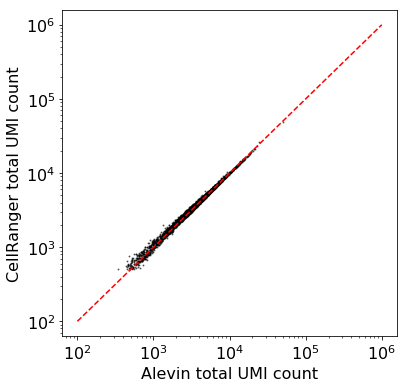

In [7]:
fig = plt.figure(figsize=(6, 6))
ax = plt.gca()
ax.plot((1e2, 1e6), (1e2, 1e6), '--', color='red')
ax.scatter(alevin_total_umi_count_per_barcode, cr_total_umi_count_per_barcode, alpha=0.5, s=1, color='black')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Alevin total UMI count', fontsize=16);
ax.set_ylabel('CellRanger total UMI count', fontsize=16);

In [51]:
# sort cb by total UMI count
from operator import itemgetter
sorted_mutual_bc_list = list(
    map(itemgetter(0),
        sorted(
            zip(mutual_cb_list, alevin_total_umi_count_per_barcode),
            key=itemgetter(1), reverse=True)))

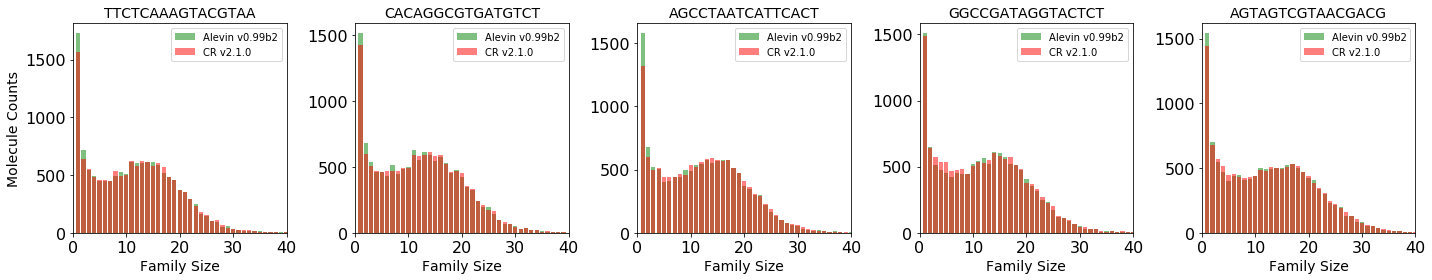

In [80]:
# compare cell-level family size distributions
cb_for_comparison = sorted_mutual_bc_list[50:55]

fig, axs = plt.subplots(
    ncols=len(cb_for_comparison),
    nrows=1,
    figsize=(4 * len(cb_for_comparison), 4))

for idx, (cb, ax) in enumerate(zip(cb_for_comparison, axs)):
    alevin_family_size_hist = cell_level_arb_hist[cb]
    cr_family_size_hist = np.asarray(sc_fingerprint_base[sc_fingerprint_base.barcode_list[cr_decoded_barcode_list.index(cb)]].sum(0)).flatten()
    ax.bar(
        np.arange(1, len(alevin_family_size_hist) + 1),
        alevin_family_size_hist, alpha=0.5, label='Alevin v0.99b2', color='green')
    ax.bar(
        np.arange(1, len(cr_family_size_hist) + 1),
        cr_family_size_hist, alpha=0.5, label='CR v2.1.0', color='red')
    ax.set_xlim((0, 40))
    if idx == 0:
        ax.set_ylabel('Molecule Counts', fontsize=14)
    ax.set_xlabel('Family Size', fontsize=14)
    ax.set_title(cb, fontsize=14)
    ax.legend()
    
plt.tight_layout()
plt.savefig('./alevin0.99b2_vs_cr210_pbmc4k.pdf')

In [8]:
sc_fingerprint_dtm = SingleCellFingerprintDTM(sc_fingerprint_base)

Calculating and caching "SingleCellFingerprintBase.total_molecules_per_gene_g"...
Calculating and caching "SingleCellFingerprintBase.sparse_count_matrix_csr"...


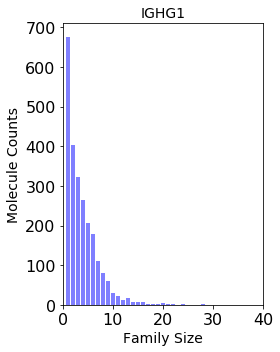

In [20]:
gene_index = sc_fingerprint_base.gene_names_list.index('IGHG1')
cr_family_size_hist = sc_fingerprint_dtm.get_single_gene_dense_fingerprint_array(gene_index).sum(0)

fig = plt.figure(figsize=(4, 5))
ax = plt.gca()
ax.bar(
    np.arange(1, len(cr_family_size_hist) + 1),
    cr_family_size_hist, alpha=0.5, label='CR v2.1.0', color='blue')
ax.set_xlim((0, 40))
ax.set_ylabel('Molecule Counts', fontsize=14)
ax.set_xlabel('Family Size', fontsize=14)
ax.set_title(sc_fingerprint_base.gene_names_list[gene_index], fontsize=14)
# ax.legend()
plt.tight_layout()
plt.savefig(f'family_size_hist_{sc_fingerprint_base.gene_names_list[gene_index]}.pdf')

## Gene expression

In [143]:
from scipy.io import mmread
import gzip

In [112]:
alevin_expr_matrix = mmread(os.path.join(alevin_output_root, 'quants_mat.mtx.gz'))

In [144]:
alevin_expr_matrix_rows = []
alevin_expr_matrix_cols = []

with open(os.path.join(alevin_output_root, 'quants_mat_cols.txt'), 'r') as f:
    for line in f:
        alevin_expr_matrix_cols.append(line.strip())
with open(os.path.join(alevin_output_root, 'quants_mat_rows.txt'), 'r') as f:
    for line in f:
        alevin_expr_matrix_rows.append(line.strip())

In [154]:
alevin_total_gene_expr_per_cell = np.asarray(alevin_expr_matrix.sum(0)).flatten() / alevin_expr_matrix.shape[0]
alevin_total_gene_expr_sorted = sorted(zip(alevin_total_gene_expr_per_cell, alevin_expr_matrix_cols), key=itemgetter(0), reverse=True)

In [158]:
cr_total_gene_expr_sorted = list(zip(sc_fingerprint_dtm.arithmetic_mean_obs_expr_per_gene, sc_fingerprint_base.gene_names_list))

In [160]:
cr_total_gene_expr_sorted[:20]

[(207.37343, 'MALAT1'),
 (64.9338, 'TMSB4X'),
 (57.171017, 'RPS27'),
 (55.931892, 'B2M'),
 (46.82389, 'EEF1A1'),
 (41.039253, 'RPL10'),
 (40.515385, 'RPL41'),
 (39.02525, 'RPL34'),
 (38.81816, 'RPL21'),
 (38.21027, 'RPL13'),
 (35.612984, 'RPL13A'),
 (34.205814, 'RPS18'),
 (33.424572, 'RPLP1'),
 (31.178867, 'RPS29'),
 (30.836834, 'RPL39'),
 (30.527477, 'RPL32'),
 (30.227032, 'RPS2'),
 (28.86272, 'RPS12'),
 (28.735624, 'MT-CO1'),
 (28.677063, 'ACTB')]

In [161]:
alevin_total_gene_expr_sorted[:20]

[(56.196587537091986, 'ENSG00000205542.11'),
 (45.23924332344214, 'ENSG00000177954.14'),
 (45.03097181008902, 'ENSG00000166710.20'),
 (39.569547477744806, 'ENSG00000156508.18'),
 (39.13241839762611, 'ENSG00000229117.9'),
 (37.626109353857565, 'ENSG00000147403.16'),
 (33.810830860534125, 'ENSG00000122026.10'),
 (33.66672848664688, 'ENSG00000109475.16'),
 (33.064910979228486, 'ENSG00000167526.13'),
 (31.010571216617212, 'ENSG00000142541.17'),
 (29.844584569732937, 'ENSG00000231500.7'),
 (29.050445103857566, 'ENSG00000137818.12'),
 (26.466060830860535, 'ENSG00000198918.8'),
 (26.457529673590503, 'ENSG00000140988.16'),
 (26.062314540059347, 'ENSG00000144713.12'),
 (25.28432437147625, 'ENSG00000164587.13'),
 (25.16190652818991, 'ENSG00000112306.8'),
 (24.506305637982194, 'ENSG00000198804.2'),
 (24.253152818991097, 'ENSG00000075624.16'),
 (24.173961424332344, 'ENSG00000137154.12')]

In [168]:
alevin_expr_matrix_cols.index('ENSG00000251562.8')

ValueError: 'ENSG00000251562.8' is not in list